In [1]:
# 모듈 로딩
# -Model 관련
import torch
import torch.nn as nn
import torch.nn.functional as F # 변수명과 헷갈릴까봐 소문자는 사용 X

from torch.utils.data import Dataset, DataLoader
import torch.optim as optim

from torchmetrics.classification import F1Score, BinaryF1Score
from torchmetrics.classification import BinaryConfusionMatrix

from torchinfo import summary

# - Data 및 시각화 관련

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import * 
from sklearn.model_selection import train_test_split 


#사용자 정의 함수
from  myfunc import *
from my_module import SmokingBCFModel
from my_module import SmokingDataset

In [2]:
DATA_FILE='diabetes_binary_health_indicators_BRFSS2021.csv'

DF=pd.read_csv(DATA_FILE)

DF.head()

,Diabetes_binary,HighBP,HighChol,CholCheck,BMI,Smoker,Stroke,HeartDiseaseorAttack,PhysActivity,Fruits,...,AnyHealthcare,NoDocbcCost,GenHlth,MentHlth,PhysHlth,DiffWalk,Sex,Age,Education,Income
0,0.0,0,1.0,1,15.0,1.0,0.0,0.0,0,1,...,1,0.0,5.0,10.0,20.0,0.0,0,11,4.0,5.0
1,1.0,1,0.0,1,28.0,0.0,0.0,1.0,0,1,...,1,0.0,2.0,0.0,0.0,0.0,0,11,4.0,3.0
2,1.0,1,1.0,1,33.0,0.0,0.0,0.0,1,1,...,1,0.0,2.0,10.0,0.0,0.0,0,9,4.0,7.0
3,1.0,0,1.0,1,29.0,0.0,1.0,1.0,1,1,...,1,0.0,5.0,0.0,30.0,1.0,1,12,3.0,4.0
4,0.0,0,0.0,1,24.0,1.0,0.0,0.0,0,0,...,1,0.0,3.0,0.0,0.0,1.0,1,13,5.0,6.0


In [3]:
# 중복 확인
DF.duplicated().sum()

13135

In [4]:
# 중복 제거
DF=DF.drop_duplicates(keep='last')

In [5]:
DF.reset_index(drop=True, inplace=True)
DF

,Diabetes_binary,HighBP,HighChol,CholCheck,BMI,Smoker,Stroke,HeartDiseaseorAttack,PhysActivity,Fruits,...,AnyHealthcare,NoDocbcCost,GenHlth,MentHlth,PhysHlth,DiffWalk,Sex,Age,Education,Income
0,0.0,0,1.0,1,15.0,1.0,0.0,0.0,0,1,...,1,0.0,5.0,10.0,20.0,0.0,0,11,4.0,5.0
1,1.0,1,0.0,1,28.0,0.0,0.0,1.0,0,1,...,1,0.0,2.0,0.0,0.0,0.0,0,11,4.0,3.0
2,1.0,1,1.0,1,33.0,0.0,0.0,0.0,1,1,...,1,0.0,2.0,10.0,0.0,0.0,0,9,4.0,7.0
3,1.0,0,1.0,1,29.0,0.0,1.0,1.0,1,1,...,1,0.0,5.0,0.0,30.0,1.0,1,12,3.0,4.0
4,0.0,0,0.0,1,24.0,1.0,0.0,0.0,0,0,...,1,0.0,3.0,0.0,0.0,1.0,1,13,5.0,6.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
223238,1.0,1,1.0,1,21.0,0.0,0.0,0.0,1,1,...,1,0.0,4.0,0.0,0.0,0.0,1,10,2.0,3.0
223239,0.0,1,0.0,1,25.0,1.0,0.0,0.0,1,1,...,0,1.0,2.0,20.0,0.0,0.0,0,3,4.0,5.0
223240,0.0,0,1.0,1,31.0,0.0,0.0,0.0,1,1,...,1,0.0,2.0,0.0,0.0,0.0,1,7,6.0,10.0
223241,0.0,1,0.0,1,24.0,0.0,0.0,0.0,1,1,...,1,0.0,2.0,0.0,0.0,0.0,1,10,4.0,6.0


In [6]:
DF.corr()['Smoker']


Diabetes_binary         0.047151
HighBP                  0.085947
HighChol                0.073251
CholCheck              -0.008140
BMI                     0.000947
Smoker                  1.000000
Stroke                  0.052529
HeartDiseaseorAttack    0.105128
PhysActivity           -0.081263
Fruits                 -0.059096
Veggies                -0.004898
HvyAlcoholConsump       0.094064
AnyHealthcare          -0.018418
NoDocbcCost             0.040462
GenHlth                 0.147932
MentHlth                0.073303
PhysHlth                0.103431
DiffWalk                0.114700
Sex                     0.075547
Age                     0.121648
Education              -0.161919
Income                 -0.130663
Name: Smoker, dtype: float64

In [7]:
DF.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 223243 entries, 0 to 223242
Data columns (total 22 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   Diabetes_binary       223243 non-null  float64
 1   HighBP                223243 non-null  int64  
 2   HighChol              223243 non-null  float64
 3   CholCheck             223243 non-null  int64  
 4   BMI                   223243 non-null  float64
 5   Smoker                223243 non-null  float64
 6   Stroke                223243 non-null  float64
 7   HeartDiseaseorAttack  223243 non-null  float64
 8   PhysActivity          223243 non-null  int64  
 9   Fruits                223243 non-null  int64  
 10  Veggies               223243 non-null  int64  
 11  HvyAlcoholConsump     223243 non-null  int64  
 12  AnyHealthcare         223243 non-null  int64  
 13  NoDocbcCost           223243 non-null  float64
 14  GenHlth               223243 non-null  float64
 15  

In [8]:
DF['Smoker'].astype(int)

0         1
1         0
2         0
3         0
4         1
         ..
223238    0
223239    1
223240    0
223241    0
223242    0
Name: Smoker, Length: 223243, dtype: int32

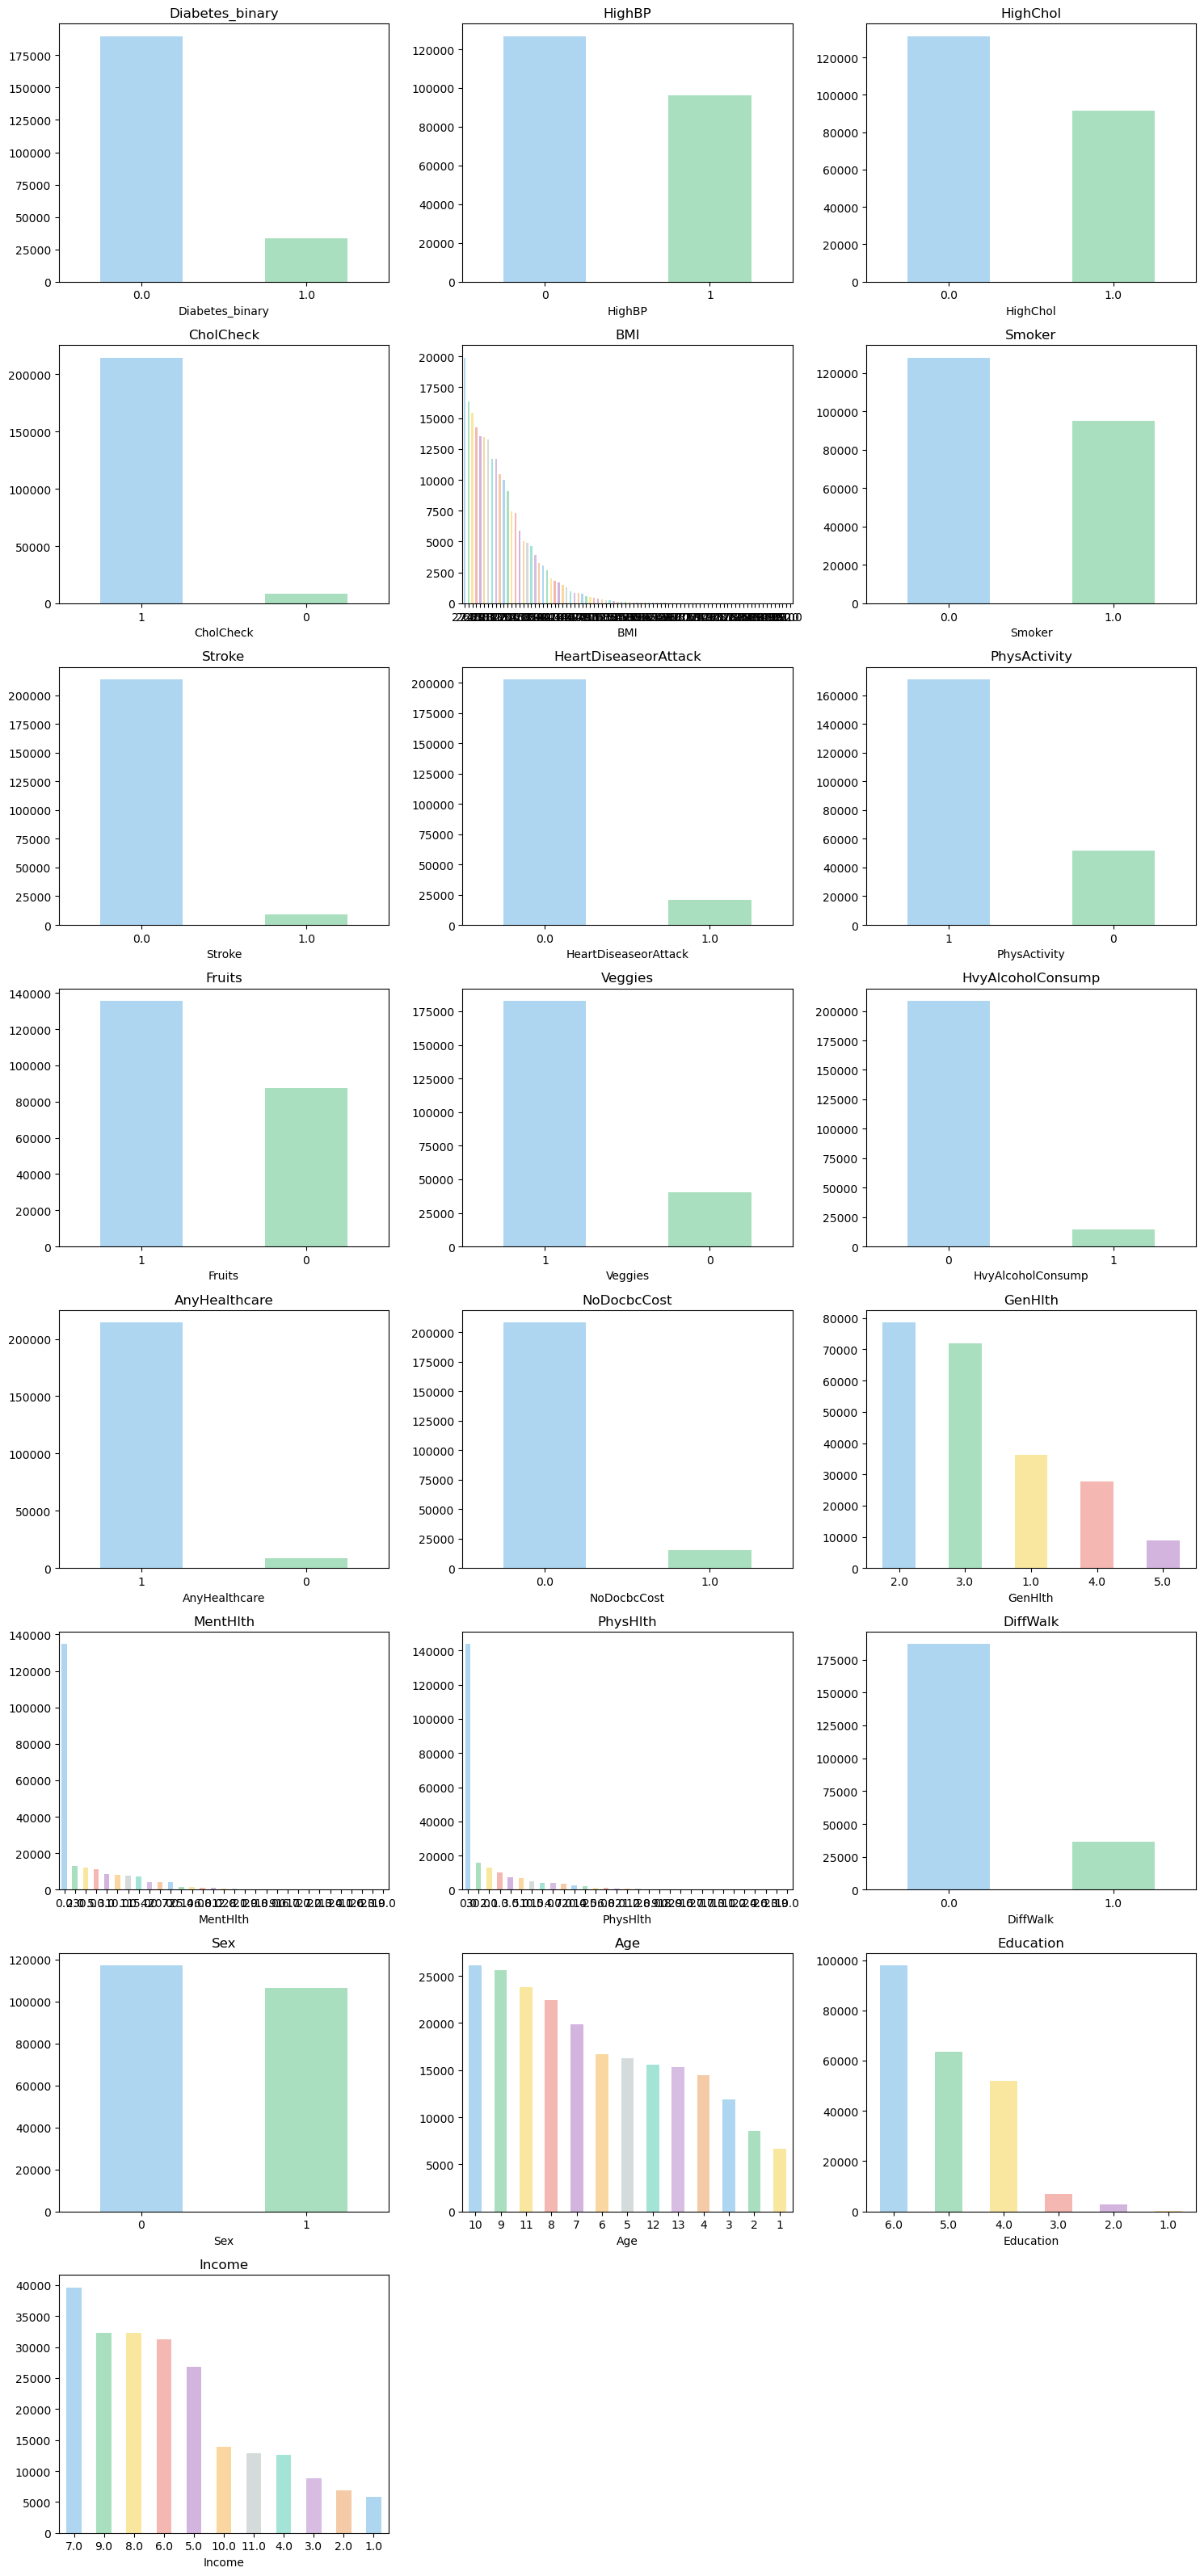

In [9]:
draw_bar(DF)

In [10]:
# - DataFrame에서 피쳐와 타겟 추출

targetDF = DF['Smoker']  .to_frame(name='Smoker')    # 2D (150, 1)
featureDF = DF.drop('Smoker',axis=1)    # 2D (150, 3)


In [11]:
targetDF

,Smoker
0,1.0
1,0.0
2,0.0
3,0.0
4,1.0
...,...
223238,0.0
223239,1.0
223240,0.0
223241,0.0


In [12]:
featureDF

,Diabetes_binary,HighBP,HighChol,CholCheck,BMI,Stroke,HeartDiseaseorAttack,PhysActivity,Fruits,Veggies,...,AnyHealthcare,NoDocbcCost,GenHlth,MentHlth,PhysHlth,DiffWalk,Sex,Age,Education,Income
0,0.0,0,1.0,1,15.0,0.0,0.0,0,1,1,...,1,0.0,5.0,10.0,20.0,0.0,0,11,4.0,5.0
1,1.0,1,0.0,1,28.0,0.0,1.0,0,1,0,...,1,0.0,2.0,0.0,0.0,0.0,0,11,4.0,3.0
2,1.0,1,1.0,1,33.0,0.0,0.0,1,1,1,...,1,0.0,2.0,10.0,0.0,0.0,0,9,4.0,7.0
3,1.0,0,1.0,1,29.0,1.0,1.0,1,1,1,...,1,0.0,5.0,0.0,30.0,1.0,1,12,3.0,4.0
4,0.0,0,0.0,1,24.0,0.0,0.0,0,0,0,...,1,0.0,3.0,0.0,0.0,1.0,1,13,5.0,6.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
223238,1.0,1,1.0,1,21.0,0.0,0.0,1,1,1,...,1,0.0,4.0,0.0,0.0,0.0,1,10,2.0,3.0
223239,0.0,1,0.0,1,25.0,0.0,0.0,1,1,1,...,0,1.0,2.0,20.0,0.0,0.0,0,3,4.0,5.0
223240,0.0,0,1.0,1,31.0,0.0,0.0,1,1,1,...,1,0.0,2.0,0.0,0.0,0.0,1,7,6.0,10.0
223241,0.0,1,0.0,1,24.0,0.0,0.0,1,1,1,...,1,0.0,2.0,0.0,0.0,0.0,1,10,4.0,6.0


In [13]:
# 활용 패키지 버전 체크 ==> 사용자 정의 함수로 구현하기
print(f'Pytorch v.{torch.__version__}')
print(f'Pandas v.{pd.__version__}')

Pytorch v.2.4.1
Pandas v.2.0.3


In [14]:
### [테스트] 모델 인스턴스 생성
model = SmokingBCFModel()

print(model)

SmokingBCFModel(
  (in_layer): Linear(in_features=21, out_features=10, bias=True)
  (hd_layer1): Linear(in_features=10, out_features=30, bias=True)
  (hd_layer2): Linear(in_features=30, out_features=60, bias=True)
  (hd_layer3): Linear(in_features=60, out_features=30, bias=True)
  (hd_layer4): Linear(in_features=30, out_features=10, bias=True)
  (hd_layer5): Linear(in_features=10, out_features=5, bias=True)
  (out_layer): Linear(in_features=5, out_features=1, bias=True)
)


In [15]:
### [테스트] 모델 사용 메모리 정보 확인
summary(model,input_size=(2000,21))

Layer (type:depth-idx)                   Output Shape              Param #
SmokingBCFModel                          [2000, 1]                 --
├─Linear: 1-1                            [2000, 10]                220
├─Linear: 1-2                            [2000, 30]                330
├─Linear: 1-3                            [2000, 60]                1,860
├─Linear: 1-4                            [2000, 30]                1,830
├─Linear: 1-5                            [2000, 10]                310
├─Linear: 1-6                            [2000, 5]                 55
├─Linear: 1-7                            [2000, 1]                 6
Total params: 4,611
Trainable params: 4,611
Non-trainable params: 0
Total mult-adds (M): 9.22
Input size (MB): 0.17
Forward/backward pass size (MB): 2.34
Params size (MB): 0.02
Estimated Total Size (MB): 2.52

In [16]:
## [테스트] 데이터셋 인스턴스 생성

# - 커스텀데이터셋 인스턴스 생성
irisDS = SmokingDataset(featureDF, targetDF)

# - 데이터로더 인스턴스 생성
irisDL = DataLoader(irisDS)
for feature, label in irisDL:
    print(feature.shape, label.shape, feature, label)
    break

torch.Size([1, 21]) torch.Size([1, 1]) tensor([[ 0.,  0.,  1.,  1., 15.,  0.,  0.,  0.,  1.,  1.,  0.,  1.,  0.,  5.,
         10., 20.,  0.,  0., 11.,  4.,  5.]]) tensor([[1.]])


In [17]:
### 학습 진행 관련 설정
EPOCH = 15

BATCH_SIZE = 2000 # 전체 데이터 수 확인후 지정 
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
LR = 0.05  # 하이퍼파라미터, 값이 적을수록 촘촘하게 내려감

In [18]:
#  모델 인스턴스
model=SmokingBCFModel()

In [19]:
# DS과 DL인스턴스
# - 학습용, 검증용, 테스트용 데이터분리
X_train, X_test, y_train, y_test = train_test_split(featureDF,targetDF, random_state=1)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, random_state=1)

print(f'{X_train.shape} {X_test.shape} {X_val.shape}')
print(f'{y_train.shape} {y_test.shape} {y_val.shape}')
print(f'{y_train.value_counts()/y_train.shape[0]}{y_test.value_counts()/y_test.shape[0]}{y_val.value_counts()/y_val.shape[0]}')
print(f'{type(X_train)} {type(X_test)} {type(X_val)}')

# 학습용, 검증용, 테스트용 데이터셋
trainDS=SmokingDataset(X_train,y_train)
valDS=SmokingDataset(X_val,y_val)
testDS=SmokingDataset(X_test,y_test)


# - 학습용 데이터로더 인스턴스
trainDL=DataLoader(trainDS, batch_size=BATCH_SIZE)

(125574, 21) (55811, 21) (41858, 21)
(125574, 1) (55811, 1) (41858, 1)
Smoker
0.0       0.572634
1.0       0.427366
Name: count, dtype: float64Smoker
0.0       0.57417
1.0       0.42583
Name: count, dtype: float64Smoker
0.0       0.576736
1.0       0.423264
Name: count, dtype: float64
<class 'pandas.core.frame.DataFrame'> <class 'pandas.core.frame.DataFrame'> <class 'pandas.core.frame.DataFrame'>


In [20]:
# 최적화 인스턴스 => w,b 텐서 즉, model.parameters() 전달
optimizer=optim.Adam(model.parameters(), lr=LR)

# 손실함수 인스턴스 => 분류 => 이진분류 BinaryCrossEntropyLoss => BCELoss
#                             예측값은 확률값으로 전달 ==> sigmoid() AF 처리후 전달
reqLoss=nn.BCELoss()

In [21]:
len(trainDL), trainDL.__len__()

(63, 63)

In [22]:
## 학습의 효과 확인 손실값과 성능평가값 저장 필요
LOSS_HISTORY, SCORE_HISTORY = [[], []], [[], []]
CNT = len(trainDL)
print(f'CNT =>  {CNT}')


for epoch in range(EPOCH):

    # 학습 모드로 모델 설정
    model.train()

    # 배치 크기 만큼 데이터 로딩해서 학습 진행
    loss_total, score_total=0,0

    for featureTS, targetTS in trainDL:
        # 학습 진행 
        pre_y=model(featureTS)

        # 손실 계산
        loss = reqLoss(pre_y,targetTS)
        loss_total += loss.item()

        # 성능평가 계산
        #score= F1Score(task='binary')(pre_y,targetTS)
        score = BinaryF1Score()(pre_y, targetTS)
        score_total += score.item() # 텐서이기 때문에 .item() 해줘야 정수가 들어감

        # 최적화 진행
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    # 에포트 당 겅증기능
    # 모델 검증 모드 설정
    model.eval()
    
    with torch.no_grad():

        # 검증 데이터셋
        val_featureTS=torch.FloatTensor(valDS.featureDF.values)
        val_targetTS=torch.FloatTensor(valDS.targetDF.values)

        #추론/평가
        pre_val=model(val_featureTS)

        #손실
        loss_val=reqLoss(pre_val,val_targetTS)
        
        # 성능평가
        score_val=BinaryF1Score()(pre_val, val_targetTS)


    # 에포크 당 손실값과 성능평가값 저장
    LOSS_HISTORY[0].append(loss_total/CNT)
    SCORE_HISTORY[0].append(score_total/CNT)


    # 손실값과 성능평가값 저장
    LOSS_HISTORY[1].append(loss_val)
    SCORE_HISTORY[1].append(score_val)


    print(f' [{epoch}/{EPOCH}]\n [TRAIN] LOSS : {LOSS_HISTORY[0][-1]}, SCORE : {SCORE_HISTORY[0][-1]}')
    print(f' [VALID] LOSS : {LOSS_HISTORY[1][-1]}, SCORE : {SCORE_HISTORY[1][-1]}')

CNT =>  63
 [0/15]
 [TRAIN] LOSS : 0.6844083799256219, SCORE : 0.026890246641068233
 [VALID] LOSS : 0.6813452243804932, SCORE : 0.0
 [1/15]
 [TRAIN] LOSS : 0.6826557971182323, SCORE : 0.0
 [VALID] LOSS : 0.6813238859176636, SCORE : 0.0
 [2/15]
 [TRAIN] LOSS : 0.6826560563511319, SCORE : 0.0
 [VALID] LOSS : 0.6813260316848755, SCORE : 0.0
 [3/15]
 [TRAIN] LOSS : 0.6826616033675179, SCORE : 0.0
 [VALID] LOSS : 0.6813259720802307, SCORE : 0.0
 [4/15]
 [TRAIN] LOSS : 0.6826558529384552, SCORE : 0.0
 [VALID] LOSS : 0.6813238859176636, SCORE : 0.0
 [5/15]
 [TRAIN] LOSS : 0.6826511233571976, SCORE : 0.0
 [VALID] LOSS : 0.6813238263130188, SCORE : 0.0
 [6/15]
 [TRAIN] LOSS : 0.6826549579226782, SCORE : 0.0
 [VALID] LOSS : 0.68132483959198, SCORE : 0.0
 [7/15]
 [TRAIN] LOSS : 0.6826609306865268, SCORE : 0.0
 [VALID] LOSS : 0.6813268661499023, SCORE : 0.0
 [8/15]
 [TRAIN] LOSS : 0.6826659459916372, SCORE : 0.0
 [VALID] LOSS : 0.6813287138938904, SCORE : 0.0
 [9/15]
 [TRAIN] LOSS : 0.682669895035

KeyboardInterrupt: 